In [282]:
import torch
import numpy as np
import utils.gradientUtils as gu
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))


threshold = 1e-9
max_iter = 1000
learning_rate = 0.03

radius = 3.0
origin=torch.tensor([5.0, 5.0], device=device)
side_length=4.0

sdf = 'circle'
#sdf = 'box'


destination = "./images/autograd/multiple_sites/"

Using device:  NVIDIA GeForce RTX 3090


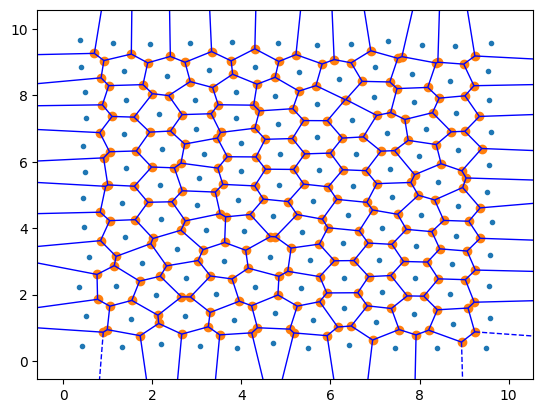

In [283]:
# Python code for creating a CVT
# Vassilis Vassiliades - Inria, Nancy - April 2018

import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans
import argparse

# Default values
num_centroids = 128
dimensionality = 2
num_samples = 100000
num_replicates = 1
max_iterations = 100000
tolerance = 0.00001
verbose = True

X = np.random.rand(num_samples,dimensionality)

kmeans = KMeans(
    init='k-means++', 
    n_clusters=num_centroids, 
    n_init=num_replicates, 
    #n_jobs=-1, 
    max_iter=max_iterations, 
    tol=tolerance,
    verbose=0)

kmeans.fit(X)
centroids = kmeans.cluster_centers_
vor = Voronoi(centroids*10)
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='blue')
# Plot the points
#plt.savefig('CVT_'f'{num_centroids}''.png',transparent=True)
plt.show()


In [284]:
centroids = np.array(centroids) * 10.0
sites = torch.from_numpy(centroids).to(device).requires_grad_(True)


#torch.manual_seed(30)
#sites = torch.rand(11, 2, dtype=torch.float32,device=device, requires_grad=True)

#sites = sites * 10.0
#print(sites)


In [285]:
def get_delaunay_neighbors_list(sites):
    # Detach and convert to NumPy for Delaunay triangulation
    points_np = sites.detach().cpu().numpy()
    
    # Compute the Delaunay triangulation
    tri = Delaunay(points_np)

    # Find the neighbors of each point
    neighbors = {i: set() for i in range(len(points_np))}
    for simplex in tri.simplices:
        # Each simplex is a triangle of three points; each point is a neighbor of the other two
        for i in range(3):
            for j in range(i + 1, 3):
                neighbors[simplex[i]].add(simplex[j])
                neighbors[simplex[j]].add(simplex[i])

    # Convert neighbor sets to lists for easier reading
    neighbors = {key: list(value) for key, value in neighbors.items()}
    return neighbors


In [286]:
def compute_vertices_index(neighbors):
    vertices_index_to_compute = []
    for site, adjacents in neighbors.items():
        for i in adjacents:
            for n in adjacents:
                if n != site and n != i and n in neighbors[i]:              
                    vertices_index_to_compute.append([i,site,n])
            
    # Set to store the canonical (sorted) version of each triplet
    seen_triplets = set()
    # Filtered list to store the unique triplets
    filtered_triplets = []
    # Process each triplet and keep only one permutation
    for triplet in vertices_index_to_compute:
        # Convert the triplet to a canonical form by sorting it
        canonical_triplet = tuple(sorted(triplet, key=str))
        # Check if this canonical triplet has been seen before
        if canonical_triplet not in seen_triplets:
            # If not seen, add it to the set and keep the triplet
            seen_triplets.add(canonical_triplet)
            filtered_triplets.append(triplet)

    return filtered_triplets

In [287]:
def compute_vertex(s_i, s_j, s_k):
    # Unpack coordinates for each site
    x_i, y_i = s_i[0], s_i[1]
    x_j, y_j = s_j[0], s_j[1]
    x_k, y_k = s_k[0], s_k[1]
    
    # Calculate numerator and  for x coordinate
    n_x = (
        x_i**2 * (y_j - y_k)
        - x_j**2 * (y_i - y_k)
        + (x_k**2 + (y_i - y_k) * (y_j - y_k)) * (y_i - y_j)
    )

    # Calculate numerator for y coordinate
    n_y = -(
        x_i**2 * (x_j - x_k)
        - x_i * (x_j**2 - x_k**2 + y_j**2 - y_k**2)
        + x_j**2 * x_k
        - x_j * (x_k**2 - y_i**2 + y_k**2)
        - x_k * (y_i**2 - y_j**2)
    )
    
    # Calculate denominator 
    d = 2 * (x_i * (y_j - y_k) - x_j * (y_i - y_k) + x_k * (y_i - y_j))
    
    # Calculate x and y coordinates
    x = n_x / d
    y = n_y / d

    # Return x, y as a tensor to maintain the computational graph
    return torch.stack([x, y])


In [288]:
def circle_sdf_loss(vertices, radius=1.0, origin=torch.tensor([0.0, 0.0])):
    # Calculate the Euclidean distance of each vertex to the specified origin
    distances = torch.norm(vertices - origin, dim=1)  # L2 norm along x and y for each vertex
    
    # Calculate the SDF value: distance to origin minus the circle radius
    sdf_values = distances - radius
    return sdf_values


In [289]:
def zerocrossing_optim(neighbors, sites):
    filtered_triplets = compute_vertices_index(neighbors)

    # List to store unique pairs of neighboring triplets with zero-crossing SDF values
    sdf_filtered_triplets = []
    # Set to track unique triplets that have already been added
    seen_triplets = set()
    
    for i in range(len(filtered_triplets)):
        count = 0
        triplet_a = set(filtered_triplets[i])
        
        for j in range(i + 1, len(filtered_triplets)):
            triplet_b = set(filtered_triplets[j])
            if count == 3:
                break
            if len(triplet_a.intersection(triplet_b)) == 2:
                vertices = [
                    compute_vertex(sites[filtered_triplets[i][0]], sites[filtered_triplets[i][1]], sites[filtered_triplets[i][2]]),
                    compute_vertex(sites[filtered_triplets[j][0]], sites[filtered_triplets[j][1]], sites[filtered_triplets[j][2]])
                ]
                vertices = torch.stack(vertices)
                
                sdf_ab = circle_sdf_loss(vertices, radius=radius, origin=origin)
                
                
                #zero et negtif pour la selection todo
                #better
                if sdf_ab[0] * sdf_ab[1] <= 0 :
                #if sdf_ab[0] * sdf_ab[1] < 0 :
                    
                    count += 1
                    triplet_a_tuple = tuple(sorted(filtered_triplets[i]))
                    triplet_b_tuple = tuple(sorted(filtered_triplets[j]))
                    
                    if triplet_a_tuple not in seen_triplets:
                        sdf_filtered_triplets.append(filtered_triplets[i])
                        seen_triplets.add(triplet_a_tuple)
                        
                    if triplet_b_tuple not in seen_triplets:
                        sdf_filtered_triplets.append(filtered_triplets[j])
                        seen_triplets.add(triplet_b_tuple)

    return sdf_filtered_triplets


In [290]:
def compute_all_vertices(sites, vertices_to_compute):
    # Initialize an empty tensor for storing vertices
    vertices = []
    
    for triplet in vertices_to_compute:
        si = sites[triplet[0]]
        sj = sites[triplet[1]]
        sk = sites[triplet[2]]
        
        # Compute vertex for the triplet (si, sj, sk)
        v = compute_vertex(si, sj, sk)
        
        # Append to the list
        vertices.append(v)
    
    # Stack the list of vertices into a single tensor for easier gradient tracking
    vertices = torch.stack(vertices)
    return vertices


In [291]:
def box_sdf_loss(vertices, side_length=4.0):
    # Calculate half side length (since box is centered at origin)
    half_side = side_length / 2.0
    
    # Compute the signed distance to the box for each vertex
    dx = torch.clamp(torch.abs(vertices[:, 0]) - half_side, min=0)  # Distance from x-axis bounds
    dy = torch.clamp(torch.abs(vertices[:, 1]) - half_side, min=0)  # Distance from y-axis bounds
    
    # Calculate the SDF as the Euclidean distance from the nearest box boundary
    sdf_values = torch.sqrt(dx**2 + dy**2)
    return sdf_values


In [292]:
def min_distance_regularization(sites):
    # Compute pairwise distances between all sites
    distances = torch.cdist(sites, sites, p=2)
    
    # Create a mask to ignore distances between a site and itself
    mask = torch.eye(distances.size(0), device=distances.device).bool()
    distances = distances.masked_fill(mask, float("inf"))

    # Calculate minimum distance for each site
    min_distances = distances.min(dim=1).values  # Minimum distance to another site for each site

    # Calculate the average of these minimum distances
    avg_min_distance = min_distances.mean()

    # Calculate penalties based on the condition provided
    #penalties = torch.clamp(min_distances - avg_min_distance, min=0)

    penalties = min_distances - avg_min_distance


    # Sum the penalties to get the regularization loss
    regularization_loss = torch.mean(torch.sum(penalties**2))
    
    return regularization_loss



In [293]:
def create_dynamic_mask(sdf_values):
    # Calculate the mean and standard deviation of the SDF values
    mean_sdf = sdf_values.mean()
    std_sdf = sdf_values.std()
    
    # Define a dynamic threshold based on the mean and standard deviation
    # For example, consider vertices within one standard deviation of the mean
    lower_threshold = mean_sdf - std_sdf
    upper_threshold = mean_sdf + std_sdf
    
    # Create a mask where SDF values fall within the dynamic range
    mask = (sdf_values > lower_threshold) & (sdf_values < upper_threshold)
    
    return mask.float()  # Convert boolean mask to float for further use


In [294]:
def compute_cvt_loss(sites):
    # Compute the Voronoi diagram based on the current site locations
    vor = Voronoi(sites.detach().cpu().numpy())
    
    centroids = []
    for i in range(len(sites)):
        # Find the region corresponding to the current site
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        
        # Check if the region is valid (i.e., finite and non-empty)
        if -1 not in region and len(region) > 0:
            # Compute the centroid as the mean of the vertices in this region
            vertices = vor.vertices[region]
            centroid = vertices.mean(axis=0)
        else:
            # For regions that are unbounded, return the site itself as the centroid
            centroid = sites[i].detach().cpu().numpy()
        
        centroids.append(centroid)
    
    centroids = torch.tensor(centroids, device=sites.device)
    
    # Calculate the CVT loss using Mean Squared Error
    cvt_loss = torch.mean(torch.norm(sites - centroids, p=2, dim=1) ** 2)
    
    return cvt_loss

In [295]:
def plot_sdf(ax):
    #plot the sdf function
    if sdf == 'circle':
        circle = plt.Circle(origin.detach().cpu().numpy(), radius, color='black', fill=False)
        ax.add_artist(circle)
    elif sdf == 'box':
        rect = plt.Rectangle((5, 5), side_length, side_length/2, fill=False, color='black')
        ax.add_artist(rect)

In [296]:
def autograd(sites, learning_rate=learning_rate, max_iter=max_iter, threshold=threshold, radius=radius):
    optimizer = torch.optim.Adam([sites], lr=learning_rate)
    prev_loss = float("inf")
    
    for epoch in range(max_iter):
        optimizer.zero_grad()
        
       
        neighbors = get_delaunay_neighbors_list(sites)
        vertices_to_compute = zerocrossing_optim(neighbors, sites)
        vertices = compute_all_vertices(sites,vertices_to_compute)

        if sdf == 'circle':
            sdf_values = circle_sdf_loss(vertices, radius=radius, origin=origin)
        elif sdf == 'box':
            sdf_values = box_sdf_loss(vertices)
        
        #sdf_mask = create_dynamic_mask(sdf_values)
        #masked_loss = (sdf_values ** 2 * sdf_mask).sum() / sdf_mask.sum()  # Normalize by the number of selected vertices
        
        
        
        # regularization loss        
        min_distance_loss = min_distance_regularization(sites)
        
        #cvt loss
        cvt_loss = compute_cvt_loss(sites)
        
        
        # Total loss
        #loss = masked_loss + min_distance_loss
        loss = 2.0*torch.mean(sdf_values**2) + cvt_loss + min_distance_loss 

        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(vertices_to_compute)
            
            sites_np = sites.detach().cpu().numpy()
            tri = Delaunay(sites_np)
            voronoi_initial = Voronoi(sites_np)
            fig, ax = plt.subplots()
            voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
            plot_sdf(ax)
            plt.xlim(0,10)
            plt.ylim(0,10)


            plt.savefig(f'{destination}multiple_'f'{sdf}_'f'{epoch}.png')
            
        if abs(prev_loss - loss.item()) < threshold:
            break
        prev_loss = loss.item()
        
    return sites

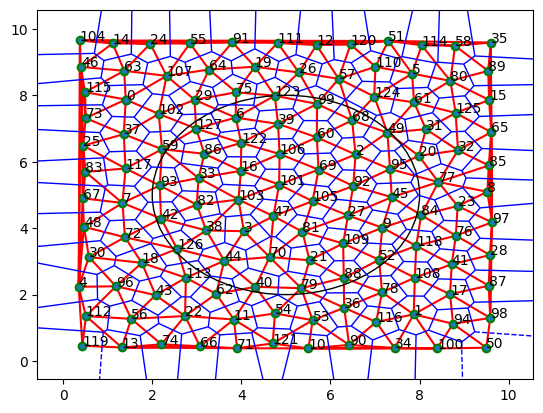

In [297]:
sites_np = sites.detach().cpu().numpy()
tri = Delaunay(sites_np)
voronoi_initial = Voronoi(sites_np)
fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
ax.triplot(sites_np[:, 0], sites_np[:, 1], tri.simplices, color='red')
plt.scatter(sites_np[0, 0], sites_np[0, 1], color='blue')
plt.scatter(sites_np[:, 0], sites_np[:, 1], color='green')

#annotate the points with their index
for i, txt in enumerate(range(len(sites_np))):
    ax.annotate(txt, (sites_np[i, 0], sites_np[i, 1]))


plot_sdf(ax)

#scaled plot
#plt.xlim(-4,4)
#plt.ylim(-4,4)

plt.savefig(f'{destination}multiple_initial.png')

plt.show()

Epoch 0: loss = 155.1803349354482
[[68, 2, 49], [68, 49, 124], [75, 6, 123], [75, 6, 29], [75, 19, 123], [29, 6, 127], [102, 29, 127], [42, 7, 93], [82, 42, 93], [84, 9, 118], [84, 76, 118], [52, 9, 118], [108, 52, 118], [40, 11, 62], [44, 40, 62], [113, 18, 126], [113, 44, 126], [32, 20, 77], [77, 20, 95], [49, 20, 31], [49, 20, 95], [79, 21, 88], [79, 36, 88], [113, 22, 62], [113, 44, 62], [77, 23, 84], [77, 45, 84], [99, 26, 123], [99, 39, 123], [59, 33, 93], [117, 59, 93], [42, 38, 126], [72, 42, 126], [70, 40, 79], [79, 40, 54], [109, 52, 88], [78, 52, 88], [99, 57, 68], [99, 60, 68], [102, 59, 127], [86, 59, 127]]
Epoch 100: loss = 0.85659739258237
[[68, 2, 49], [49, 2, 20], [68, 49, 124], [20, 2, 95], [77, 20, 95], [39, 6, 123], [75, 6, 123], [99, 39, 123], [75, 6, 29], [29, 6, 127], [102, 29, 127], [42, 7, 93], [82, 42, 93], [45, 9, 84], [84, 9, 118], [45, 23, 84], [52, 9, 118], [108, 52, 118], [40, 11, 54], [79, 40, 54], [40, 11, 62], [44, 40, 62], [113, 18, 126], [113, 44, 12

tensor([[ 2.3227,  7.4502],
        [ 7.6581, -1.2715],
        [ 7.1815,  5.6622],
        [ 2.6668,  2.7696],
        [-1.3290,  0.6955],
        [ 8.8862,  8.8329],
        [ 4.6081,  7.4356],
        [-2.0971,  4.3505],
        [ 8.2776,  4.7237],
        [ 6.4862,  4.4587],
        [ 4.5236, -1.9682],
        [ 3.9124,  0.9383],
        [ 4.3810, 12.3440],
        [ 0.6244, -0.6757],
        [ 1.5944,  8.7163],
        [11.6755,  9.5199],
        [ 4.1656,  5.4614],
        [ 8.7343,  0.9742],
        [ 1.0128,  3.2174],
        [ 3.8754, 10.2788],
        [ 9.8658,  5.8897],
        [ 4.8361,  2.4346],
        [ 3.0812,  1.1695],
        [ 7.9757,  3.7009],
        [ 1.1169, 10.4837],
        [-1.1208,  8.6560],
        [ 4.7309,  9.5465],
        [ 6.3765,  2.9866],
        [10.1303,  2.3189],
        [ 3.0963,  8.8114],
        [-0.1998,  3.8618],
        [ 9.1577,  7.4006],
        [12.0768,  6.4037],
        [ 2.4993,  5.0924],
        [ 8.7969, -1.3250],
        [10.6523, 10

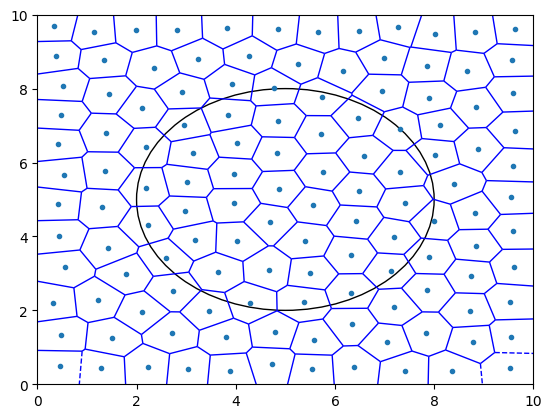

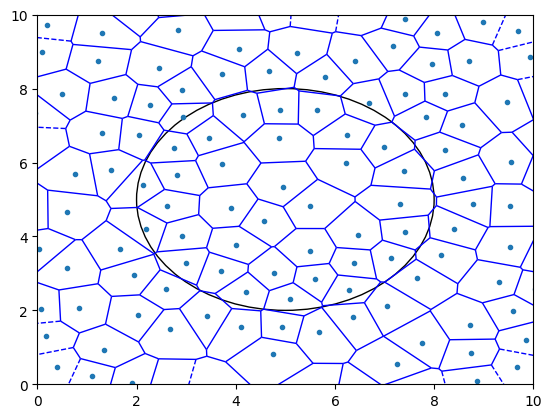

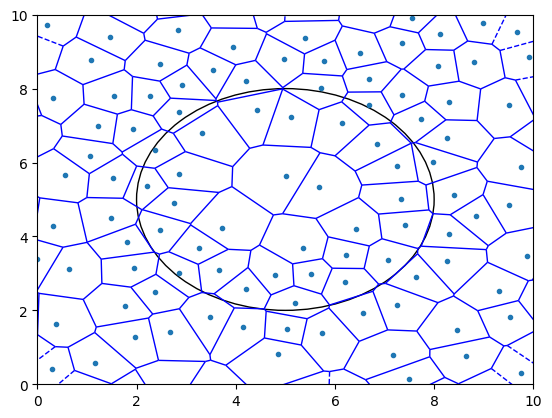

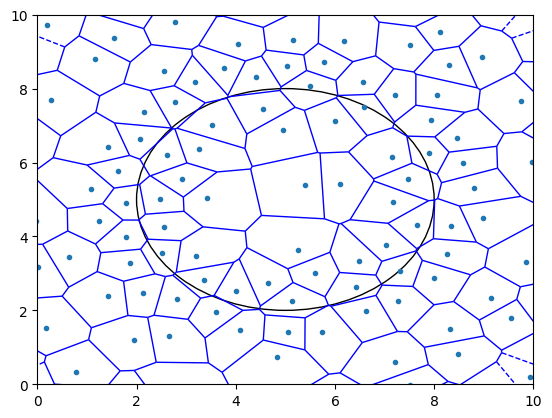

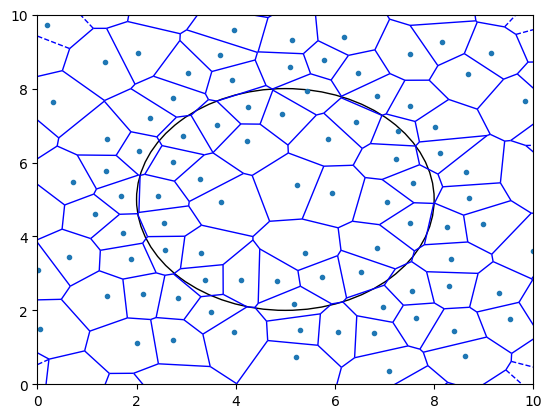

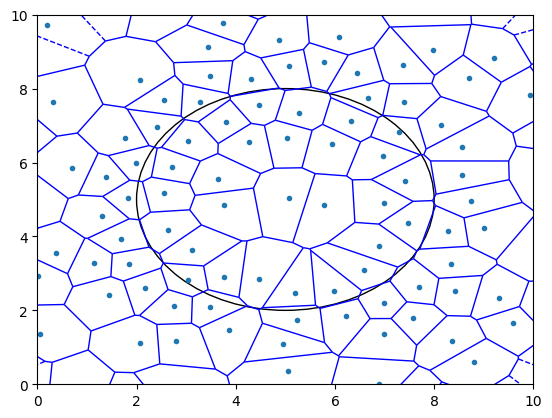

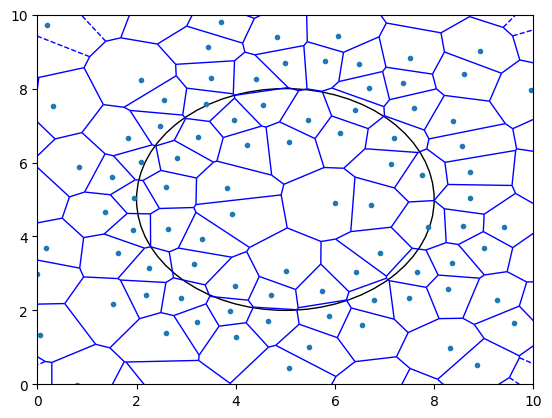

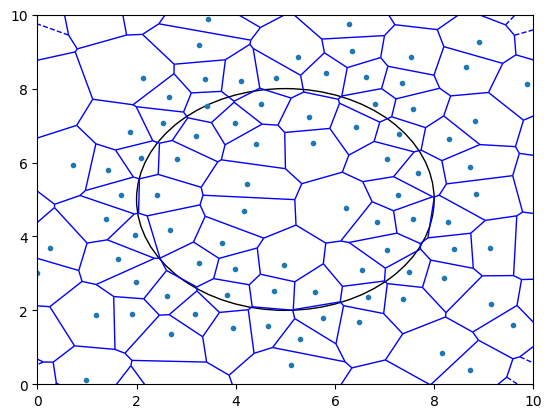

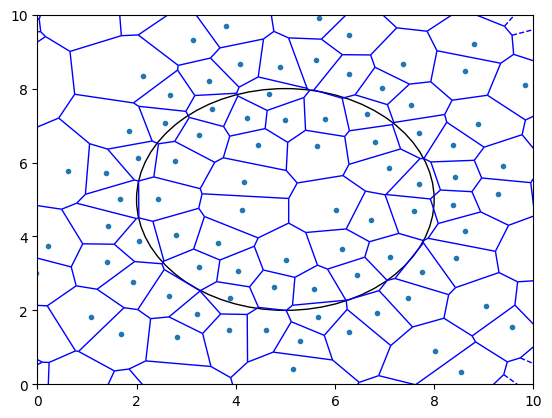

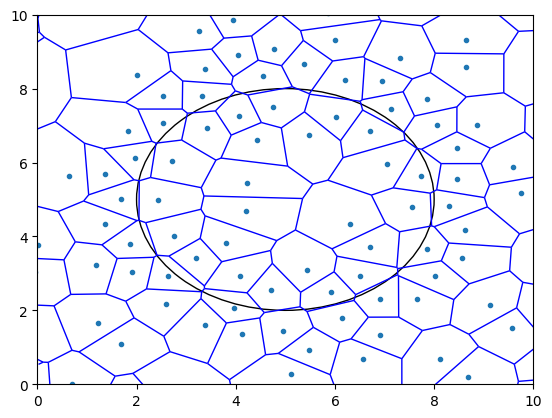

In [298]:
autograd(sites)

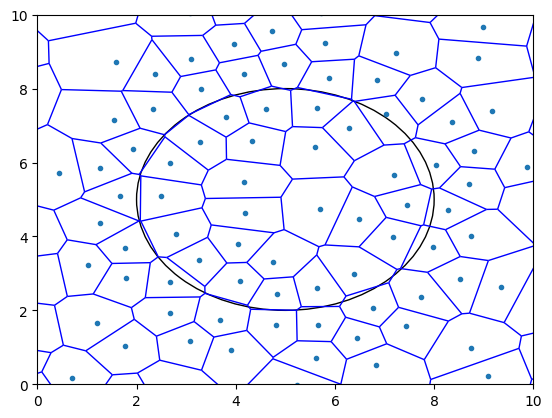

In [299]:
sites_np = sites.detach().cpu().numpy()
tri = Delaunay(sites_np)
voronoi_initial = Voronoi(sites_np)
fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
#ax.triplot(sites_np[:, 0], sites_np[:, 1], tri.simplices, color='red')
# plt.scatter(sites_np[0, 0], sites_np[0, 1], color='blue')
# plt.scatter(sites_np[:, 0], sites_np[:, 1], color='green')
# 
# annotate the points with their index
# for i, txt in enumerate(range(len(sites_np))):
#     ax.annotate(txt, (sites_np[i, 0], sites_np[i, 1]))


plot_sdf(ax)
plt.xlim(0,10)
plt.ylim(0,10)


plt.savefig(f'{destination}multiple_'f'{sdf}_'f'{max_iter}.png')

plt.show()

37
27


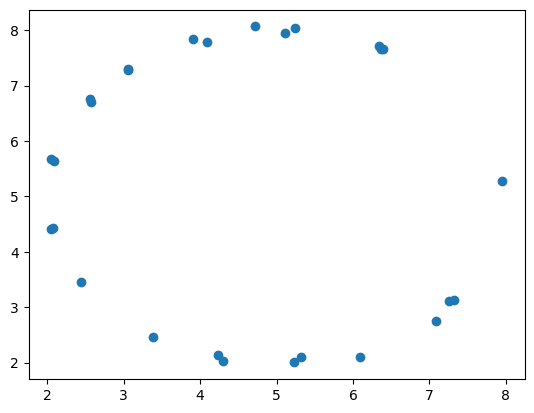

In [300]:
neighbors = get_delaunay_neighbors_list(sites)
vertices_to_compute = zerocrossing_optim(neighbors, sites)
vertices = compute_all_vertices(sites,vertices_to_compute)

vertices_np = vertices.detach().cpu().numpy()
print(len(vertices_np))
if sdf == 'circle':
    sdf_values = circle_sdf_loss(vertices, radius=radius, origin=origin)
    
#filter vertices based on sdf values
vertices_to_mesh = []
for i in range(len(vertices_np)):
    #if sdf values is around tolerance 
    if abs(sdf_values[i]) < 0.1:
        vertices_to_mesh.append(vertices_np[i])  

print(len(vertices_to_mesh));




# Convert vertices_to_mesh to a NumPy array
vertices_to_mesh = np.array(vertices_to_mesh)

#scatter vertices on a plot
fig, ax = plt.subplots()
plt.scatter(vertices_to_mesh[:,0],vertices_to_mesh[:,1])